In [1]:
import pandas as pd
import luxpy as lx # package for color science calculations 
# print('Luxpy version: ',lx.__VERSION__)
# version: v1.9.6
import numpy as np # fundamental package for scientific computing 
import matplotlib.pyplot as plt # package for plotting
import copy
from scipy import interpolate
from luxpy.toolboxes import spdbuild as spb

251


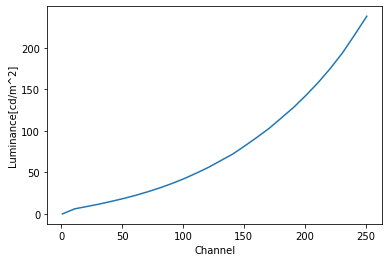

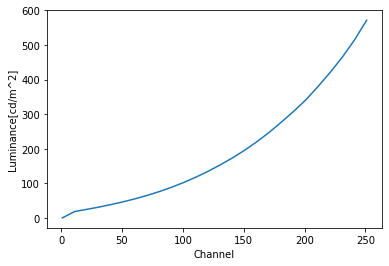

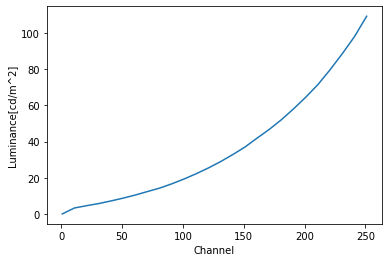

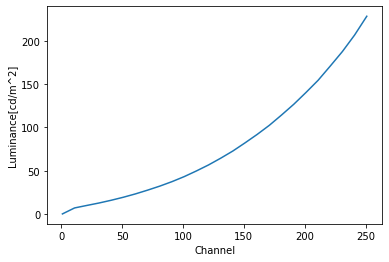

In [2]:
# get data
spdData = pd.read_csv('./data/spectrums.txt', sep=' |:', header=None, engine='python')
spdData.columns = ['Light','Channel','Value']
spdData['Luminance'] = spdData.apply(lambda x: float(lx.spd_to_power(eval(x['Value']), ptype='pu')), axis=1)
# spd_to_power(): spectral radiant power [W/nm] to luminance [cd/m^2]

for i in [1,2,3,5]:
    channel = []
    luminance = []
    for j in range(1,256,10):
        channel.append(j)
        luminance.append(spdData['Luminance'][spdData['Light']==i][spdData['Channel']==j])
    plt.figure()
    plt.plot(channel,luminance)
    plt.xlabel('Channel')
    plt.ylabel('Luminance[cd/m^2]')
    plt.show
    
#curvefitting
def ChannelValue(l:int, perc:float): #l:light(R-1,G-2,B-3,A-5), perc:percentage of the channel
    if l == 1:
        para = np.array([3.79101032e-03, -7.71247848e-02,9.17950337e+00])
        func = np.poly1d(para)
    elif l == 2:
        para = np.array([9.14054992e-03, -2.08932099e-01,2.49404590e+01])
        func = np.poly1d(para)
    elif l == 3:
        para = np.array([1.76936023e-03, -4.70784519e-02,4.83069050e+00])
        func = np.poly1d(para)
    elif l == 5:
        para = np.array([3.47076694e-03, -2.68425662e-02,8.62810845e+00])
        func = np.poly1d(para)
    
    return int([x for x in np.roots(func-perc*255) if x > 0][0])

print(ChannelValue(1,0.9))

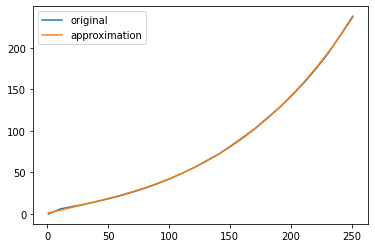

In [3]:
# Approximation
def getApproximation(x, y, n):
    apx = np.polyfit(x, y, n)
    y_apx = np.poly1d(apx)(x)
    return (x, y_apx)

channel = 1
x = range(1,256,10)
y = spdData['Luminance'][spdData['Light']==channel]
x, y_apx = getApproximation(x, y, 3)

plt.plot(x, y, label='original')
plt.plot(x, y_apx, label='approximation')
plt.legend()
plt.show()

[[7.0892e+01 3.3972e+01 -2.9182e+01]]
[[5.1835e+01 4.2030e+01 7.8054e+01]]
[[5.1835e+01 4.2030e+01 7.8054e+01]] [[4.2030e+01 3.0151e-01 2.4448e-01]]
[[6.0571e-02]
 [4.0413e-02]
 [4.1445e-02]]
[5.1835e+01 4.2030e+01 7.8054e+01]
918.6169406885249


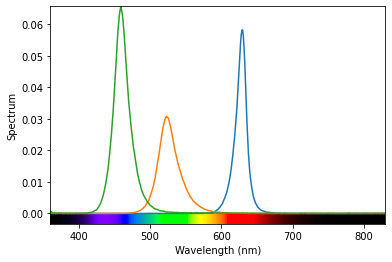

In [5]:
#print(spdData['Value'].iloc[0])
#p = np.array(copy.copy(eval(spdData['Value'].iloc[0])))
#print(p.shape)
#lx.SPD(p).plot()

# for i in range(0, 25):
#     lx.SPD(np.array(eval(spdData['Value'].iloc[i]))).plot()
   
lx.SPD(np.array(eval(spdData['Value'].iloc[25]))).plot()
lx.SPD(np.array(eval(spdData['Value'].iloc[51]))).plot()
lx.SPD(np.array(eval(spdData['Value'].iloc[77]))).plot()
#lx.SPD(np.array(eval(spdData['Value'].iloc[103]))).plot()

r_primary = np.array(copy.copy(eval(spdData['Value'].iloc[25])))
g_primary = np.array(copy.copy(eval(spdData['Value'].iloc[51])))
b_primary = np.array(copy.copy(eval(spdData['Value'].iloc[77])))

t_color = lx._CIE_ILLUMINANTS['LED_B1']
#print(e_illuminant)
#lx.SPD(lx._CIE_E).plot() 


xyzt = lx.spd_to_xyz(t_color, relative= False) # K = 1 replaces the default 683 lm/W value with 1!
xyzt = np.array([[51.8347, 42.0302, 78.0537]])

print(lx.xyz_to_lab(xyzt))
print(xyzt)
Yxyt = lx.xyz_to_Yxy(xyzt)

xyzr = lx.spd_to_xyz(r_primary, relative= False ) # K = 1 replaces the default 683 lm/W value with 1!
Yxyr = lx.xyz_to_Yxy(xyzr)
xyzg = lx.spd_to_xyz(g_primary, relative= False) # K = 1 replaces the default 683 lm/W value with 1!
Yxyg = lx.xyz_to_Yxy(xyzg)
xyzb = lx.spd_to_xyz(b_primary, relative= False) # K = 1 replaces the default 683 lm/W value with 1!
Yxyb = lx.xyz_to_Yxy(xyzb)
print(xyzt, Yxyt)
# print(xyzr[0])
# print(xyzr, xyzg, xyzb)
#print(np.linalg.inv(Yxyr[0]))
#3-channel color mixing

Cp = np.array([xyzr[0], xyzg[0], xyzb[0]]).T
#print(Cp)
w = np.linalg.inv(Cp) @ xyzt.T
print(w)
# print(Cp.T[0])
# print(xyzr)
print(w[0]*Cp.T[0] + w[1]*Cp.T[1] + w[2]*Cp.T[2])

print(Cp.sum(axis=1)[1])


In [6]:
#N-color mixing

a_primary = np.array(copy.copy(eval(spdData['Value'].iloc[103])))

xyza = lx.spd_to_xyz(a_primary, relative=False) # K = 1 replaces the default 683 lm/W value with 1!
Yxya = lx.xyz_to_Yxy(xyza)

Cp = np.array([xyzr[0], xyzg[0], xyzb[0], xyza[0]]).T

w = Cp.T @ (np.linalg.inv(Cp@Cp.T)) @ xyzt.T
print(w)
print(w[0]*Cp.T[0] + w[1]*Cp.T[1] + w[2]*Cp.T[2] + w[3]*Cp.T[3])

[[4.4019e-02]
 [3.5257e-02]
 [4.1607e-02]
 [3.0061e-02]]
[5.1835e+01 4.2030e+01 7.8054e+01]


[1.0467e+01]
[2.0149e+01]
[4.5496e+00]
[6.8649e+00]
[26, 13, 20, 10]


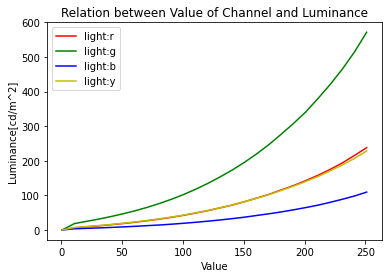

In [7]:
spdData = pd.read_csv('./data/spectrums.txt', sep=' |:', header=None, engine='python')
spdData.columns = ['Light','Channel','Value']
spdData['Luminance'] = spdData.apply(lambda x: float(lx.spd_to_power(eval(x['Value']), ptype='pu')), axis=1)
#print(spdData['Luminance'][25], spdData['Luminance'][51], spdData['Luminance'][77])
# spd_to_power(): spectral radiant power [W/nm] to luminance [cd/m^2]

largestLum = []
for i in [1,2,3,5]:
    channel = []
    luminance = []
    col = np.where(i==1, 'r', np.where(i==2, 'g', np.where(i==3, 'b', 'y')))
    for j in range(1,256,10):
        channel.append(j)
        luminance.append(spdData['Luminance'][spdData['Light']==i][spdData['Channel']==j])
    
    largestLum.append(float(luminance[-1]))    # record the largest luminance of every channel
    plt.plot(channel,luminance,str(col),label='light:'+str(col))
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Luminance[cd/m^2]')
    plt.title('Relation between Value of Channel and Luminance')
    plt.show    #plot
    
    x = np.array(channel)
    y = np.array(luminance)    
    exec('func'+str(i)+'=interpolate.UnivariateSpline(y,x,s=0)') # interpolation: pass all the points

largestLum.insert(3,None) #To easily process in function of ChannelValue


def ChannelValue(l:int, perc:float): 
    # input: l:light(R-1,G-2,B-3,A-5), perc:the percentage of the maximum luminance of the channel
    # output: the channel value(1~251)
    #print(largestLum[l-1])
    print(perc*largestLum[l-1])
    return int(eval('func'+str(l)+'('+str(perc*largestLum[l-1])+')'))   

#get luminance by normalize
# w_normalized = w / w.sum()
# print(w_normalized)

digit = []
digit.append(ChannelValue(1, w[0]))
digit.append(ChannelValue(2, w[1]))
digit.append(ChannelValue(3, w[2]))
digit.append(ChannelValue(5, w[3]))
print(digit)




[[3.6000e+02 3.6100e+02 3.6200e+02 ... 8.2800e+02 8.2900e+02 8.3000e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 4.0397e-06 1.3450e-05 0.0000e+00]
 [2.2230e-04 6.4534e-05 3.4546e-05 ... 0.0000e+00 0.0000e+00 6.0514e-05]
 [0.0000e+00 6.7309e-04 3.1529e-04 ... 9.9812e-06 8.8070e-05 1.3222e-04]
 [2.2653e-04 0.0000e+00 4.1692e-04 ... 2.9844e-05 0.0000e+00 1.8561e-05]]
Trying to 'pip install pyswarms' using subprocess.
subprocess output:  0
'pip install pyswarms' succesful

Results (optim,target):
Yxy: ([42,0.30,0.24],[42,0.30,0.24])
Rf: (75.30,90.00)
Rg: (103.13, 110.00)
cct(K), duv: (10341.9,-0.0402)

Flux ratios of component spectra: [[2.3260e-02 2.8789e-02 4.1811e-02 6.7763e-02]]
5.530721517456126
16.452740082275575
4.571827196327726
15.474911203940566
[9, 8, 20, 40]


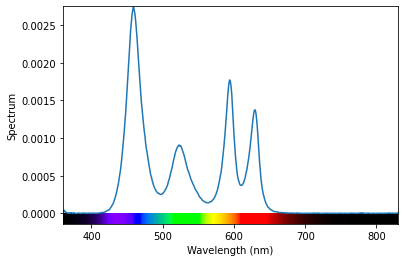

In [15]:
def spd_to_cris(spd, solution_info=None):
    #print(solution_info)
    Rf,Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30',out='Rf,Rg')
    return np.vstack((Rf, Rg))  

obj_fcn = [(spd_to_cris,'Rf','Rg')]
obj_tar_vals = [(90,110)]


# Initialize SpectralOptimizer object:
cieobs='1931_2'
prims = np.array([r_primary[0],r_primary[1], g_primary[1], b_primary[1], a_primary[1]])
print(prims)
target = Yxyt
so3 = spb.SpectralOptimizer(target = target, tar_type = 'Yxy', cspace_bwtf = {},
                      wlr = [360,830,1], cieobs = cieobs, 
                      out = 'spds,primss,Ms,results',
                      optimizer_type = '3mixer', triangle_strengths_bnds = None,
                      prim_constructor = None, 
                      prims = prims,
                      obj_fcn = spb.ObjFcns(f=obj_fcn, ft = obj_tar_vals),
                      minimizer = spb.Minimizer(method='particleswarm'),
                      verbosity = 0)

# start optimization:
S,M = so3.start(out = 'spds,Ms')

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs,out = 'cct,duv')
Rf, Rg = spd_to_cris(S)
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

digit = []
digit.append(ChannelValue(1, M[0][0]))
digit.append(ChannelValue(2, M[0][1]))
digit.append(ChannelValue(3, M[0][2]))
digit.append(ChannelValue(5, M[0][3]))
print(digit)